# Hacker News Stories

In this notebook...I used the latter option running the following query, that processed 9.7 GB when run 2019-05-05.

    SELECT * FROM `bigquery-public-data.hacker_news.full`
    WHERE score >= 50 AND type = "story" AND url != ""
    ORDER BY time DESC
    
In the code cell below, the Python libraries used in this notebook are imported, some variables set and the dataset loaded into a pandas DataFrame.

In [1]:
%matplotlib inline
%load_ext signature
import os
import re

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tld

mpl.style.use('ramiro')
default_figsize = (10, 5)
data_file = os.path.expanduser('~/data/hackernews/hackernews_popular_stories_2019-05-05.csv')
df = pd.read_csv(data_file, parse_dates=['timestamp'])
df.head()

,by,score,time,timestamp,title,type,url,text,parent,deleted,dead,descendants,id,ranking
0,workrockin,73,1557035426,2019-05-05 05:50:26+00:00,Network Offloading in Openwrt [pdf],story,https://openwrtsummit.files.wordpress.com/2018...,NaN,NaN,NaN,NaN,1.0,19831385,NaN
1,clouddrover,75,1557019551,2019-05-05 01:25:51+00:00,US Ride-Share Drivers Ready for Countrywide St...,story,https://www.thedrive.com/news/27824/us-ride-sh...,NaN,NaN,NaN,NaN,59.0,19830505,NaN
2,p1esk,166,1557012444,2019-05-04 23:27:24+00:00,OpenAI releases larger GPT-2 model,story,https://openai.com/blog/better-language-models...,NaN,NaN,NaN,NaN,33.0,19830042,NaN
3,ColinWright,77,1557009447,2019-05-04 22:37:27+00:00,Goro Shimura has died,story,https://en.wikipedia.org/wiki/Goro_Shimura,NaN,NaN,NaN,NaN,10.0,19829828,NaN
4,ingve,50,1557008719,2019-05-04 22:25:19+00:00,Learning new skills in InfoSec without getting...,story,https://azeria-labs.com/paradox-of-choice/,NaN,NaN,NaN,NaN,3.0,19829775,NaN


In [2]:
# Fixes for 
# http:////www.economist.com/science-and-technology/2018/09/06/how-a-shampoo-bottle-is-saving-young-lives
# http://jdebp.eu./FGA/operating-system-books.html
def fix_url(url):
    return url.replace('jdebp.eu.', 'jdebp.eu').replace('http:////', 'http://')

df['url'] = df.url.apply(lambda s: fix_url(s))

In [3]:
# https://stackoverflow.com/questions/42285130/how-floor-a-date-to-the-first-date-of-that-month
df['published'] = df.timestamp.dt.to_period('M').dt.to_timestamp()

/home/rg/anaconda3/envs/dm/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


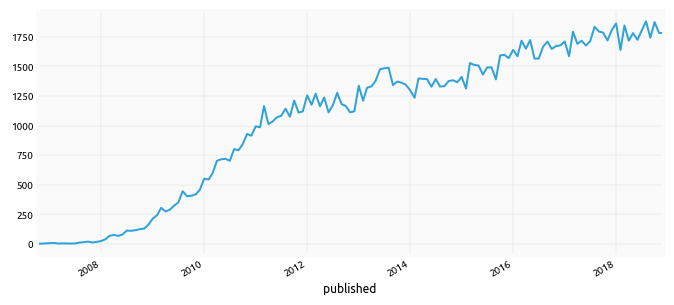

In [4]:
by_day = df.loc[df.timestamp.dt.year < 2019].groupby(df.published)
by_day.size().plot(figsize=default_figsize);

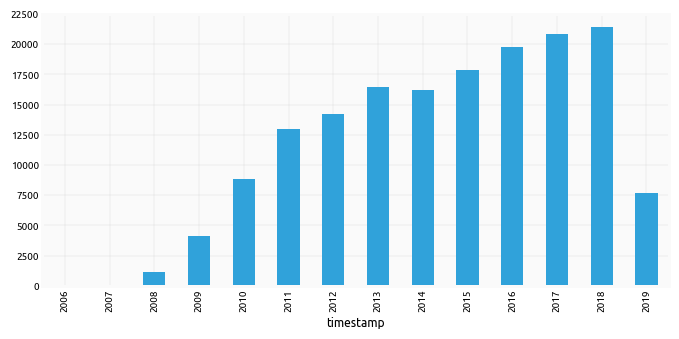

In [5]:
by_year = df.groupby(df.timestamp.dt.year)
by_year.size().plot.bar(figsize=default_figsize);

In [6]:
df['domain'] = df.url.apply(lambda s: tld.get_fld(s, fail_silently=True))
top_domains = df.domain.value_counts().head(30)

by_domain = df.groupby(df.domain)
domains_story_count = by_domain['score'].size().sort_values(ascending=False)

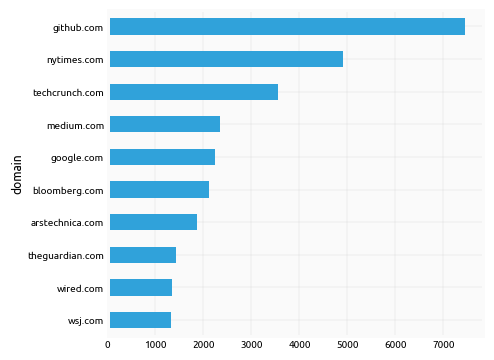

In [7]:
domains_story_count[:10][::-1].plot.barh(figsize=(6, 6));

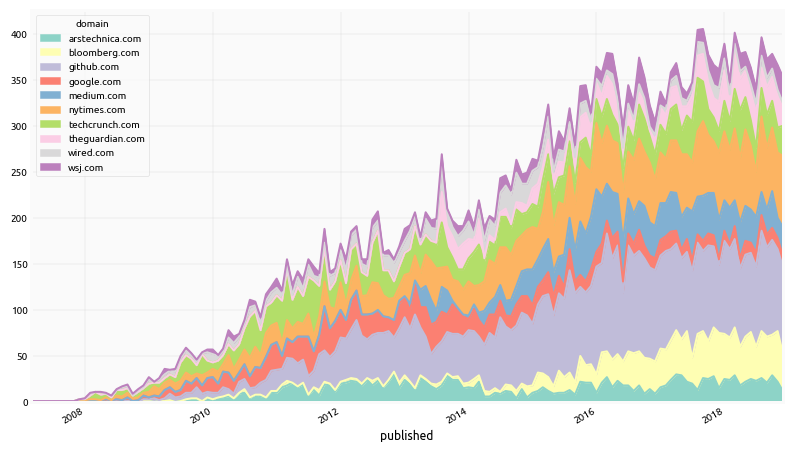

In [8]:
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd']
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', colors)

by_published_domain = df.loc[df.domain.isin(domains_story_count[:10].index) & (df.timestamp.dt.year < 2019)].groupby(['published', 'domain'])
by_published_domain.size().unstack().plot(kind='area', figsize=(12, 8), stacked=True, colormap=cmap)

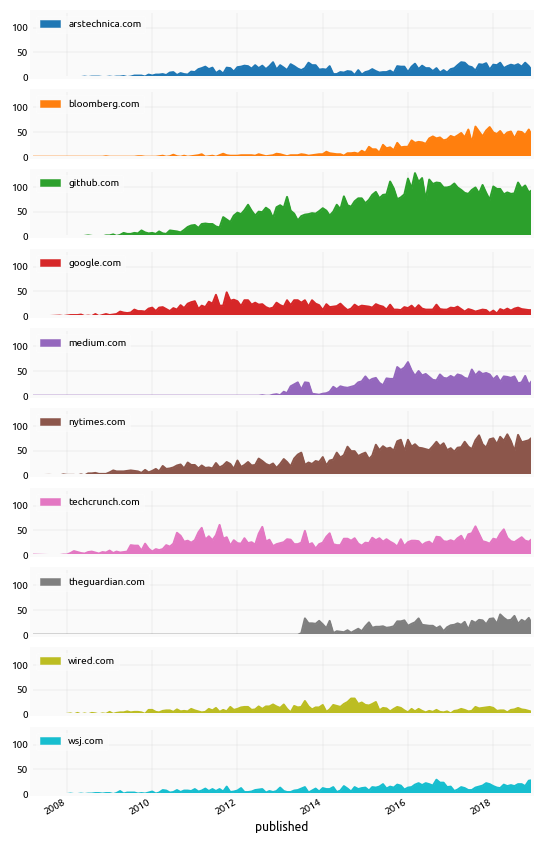

In [9]:
by_published_domain.size().unstack().plot.area(figsize=(8, 16), subplots=True, sharey=True, colormap='tab10')
[ax.legend(loc=2, edgecolor=(1,1,1,0)) for ax in plt.gcf().axes];